# Step 1: Import all the necessary Libraries

In [8]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

# Step 2: Download the Dataset

In [9]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

## Downloaded the URLs of grizzly bears

In [11]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

## Set the destination folder url and download a single image from those url to check

In [12]:
dest = 'images/grizzly_beer.jpg'
download_url(ims[0], dest, show_progress=True)

Path('images/grizzly_beer.jpg')

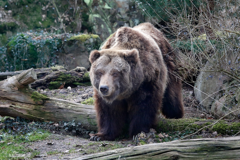

In [13]:
im = Image.open(dest)
im.to_thumb(240,240)

## Now, we are convinced that the image we searched for is correct. Let's start by creating the dataset!

In [22]:
label_type = ['grizzly', 'black', 'teddy']
path = Path('bears')

In [31]:
unsuccessFullPass = 0
if not path.exists():
    path.mkdir()
    for label in label_type:
        dest = (path/label)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{label} bear')
        for imgUrl in results:
            try:
                download_url(imgUrl, dest, show_progress=False)
            except:
                unsuccessFullPass += 1

### Let's See how many broken url we fetched!

In [32]:
print(f"Total Unsuccessfull Attempts/URL's = {unsuccessFullPass}")

Total Unsuccessfull Attempts/URL's = 14


In [33]:
fns = get_image_files(path)
fns

(#549) [Path('bears/teddy/crochet-teddy-bears.jpg'),Path('bears/teddy/Cute-Teddy-Bear-Wallpaper-15.jpg'),Path('bears/teddy/fresh-red-rose-teddy-bear-gift.jpg'),Path('bears/teddy/Draw-a-Teddy-Bear-Step-33.jpg'),Path('bears/teddy/image.jpg'),Path('bears/teddy/IMG_1846.JPG'),Path('bears/teddy/cute-teddy-bear-15.jpg'),Path('bears/teddy/1905-Bear-.jpg'),Path('bears/teddy/Images-of-Teddy-Bears-5.jpg'),Path('bears/teddy/490546.jpg')...]

## when we download files from the internet, there are a few that are corrupt. Let's check

In [34]:
failed = verify_images(fns)
failed

(#27) [Path('bears/teddy/image.jpg'),Path('bears/teddy/c2dbfjwgbnd41.png'),Path('bears/teddy/045.JPG'),Path('bears/teddy/P1090890.JPG'),Path('bears/teddy/7029745-teddy-bear-images.jpg'),Path('bears/teddy/teddy-bear.jpg'),Path('bears/teddy/150820111374-2.jpg'),Path('bears/teddy/6932786-cute-teddy-bear-couples.jpg'),Path('bears/teddy/Image%20One.JPG'),Path('bears/teddy/photo%202.JPG')...]

### To remove all the failed images, you can use unlink on each of them

In [35]:
failed.map(Path.unlink);

# Step 3: Start Working on your DataSet
## Let's Create the data loader

In [37]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

## We still need to tell fastai the actual source of our data in this case, the path where the images can be found:

In [38]:
dls = bears.dataloaders(path)

### Let's See the Validation Set!

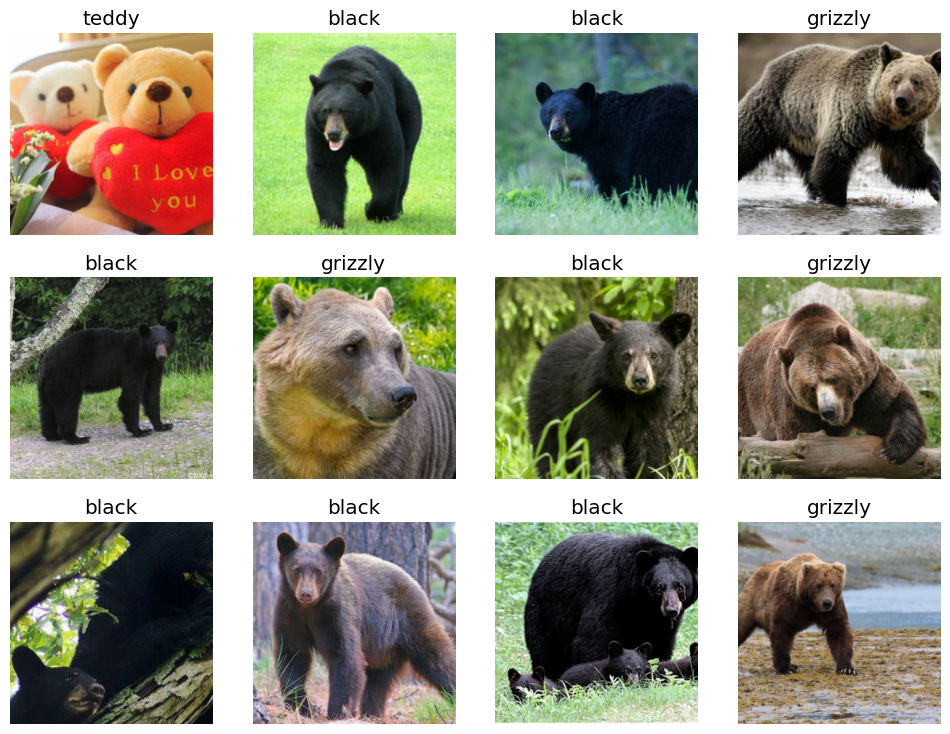

In [40]:
dls.valid.show_batch(max_n=12, nrows=3)

### Let's See the Train Set!

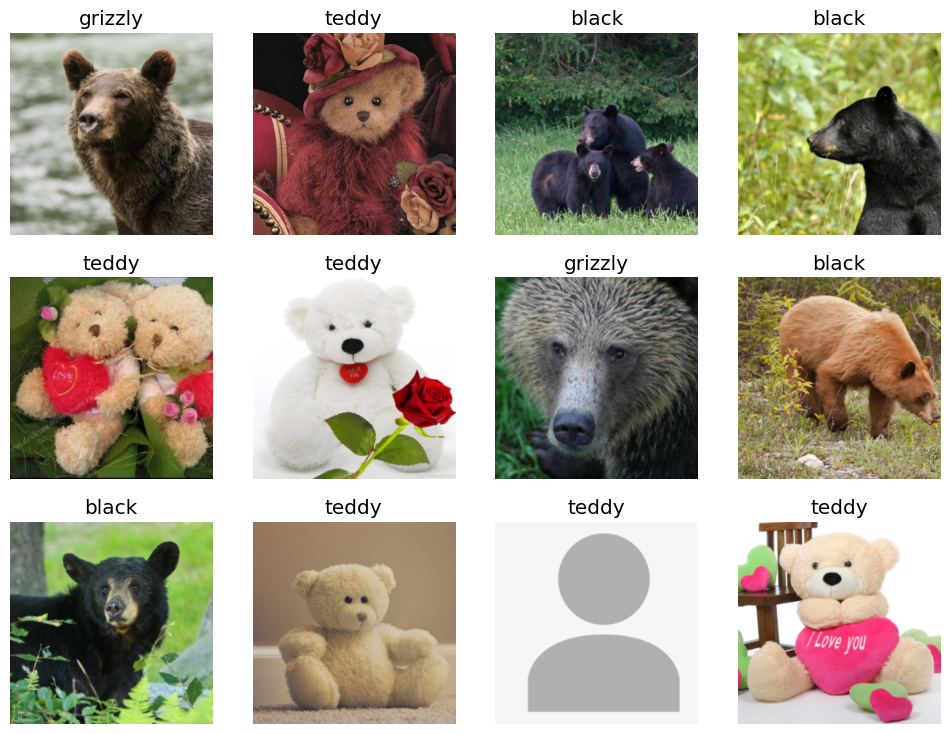

In [41]:
dls.train.show_batch(max_n=12, nrows=3)

### Resize Method: Squish example!

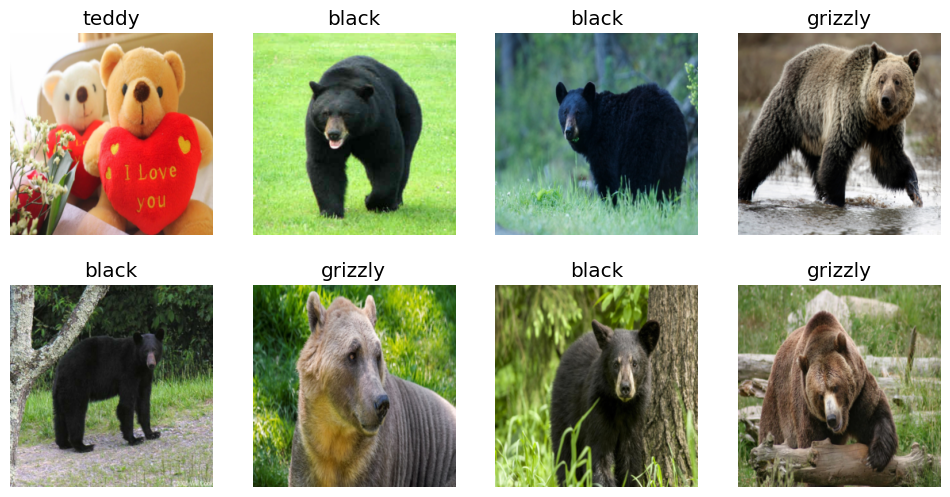

In [42]:
bears = bears.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

### Resize Method: Padding example!

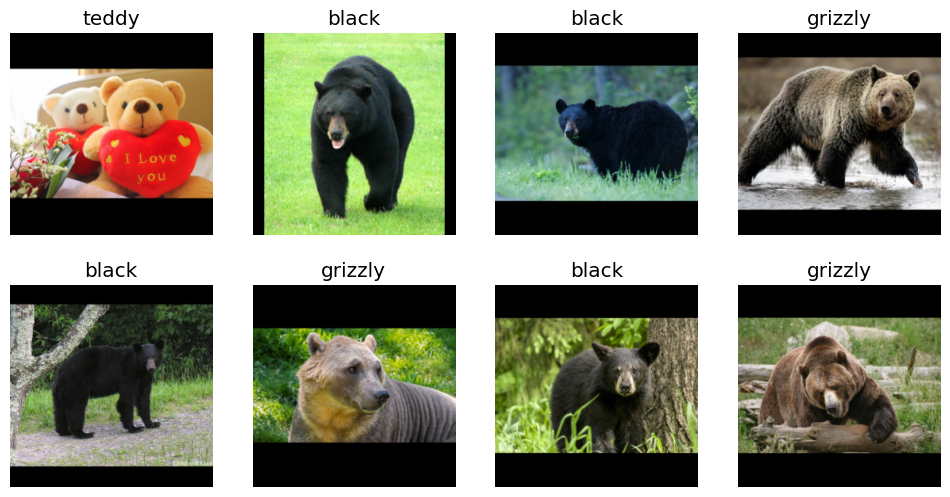

In [43]:
bears = bears.new(item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

## Let's randomly select part of the image, and crop to just that part!

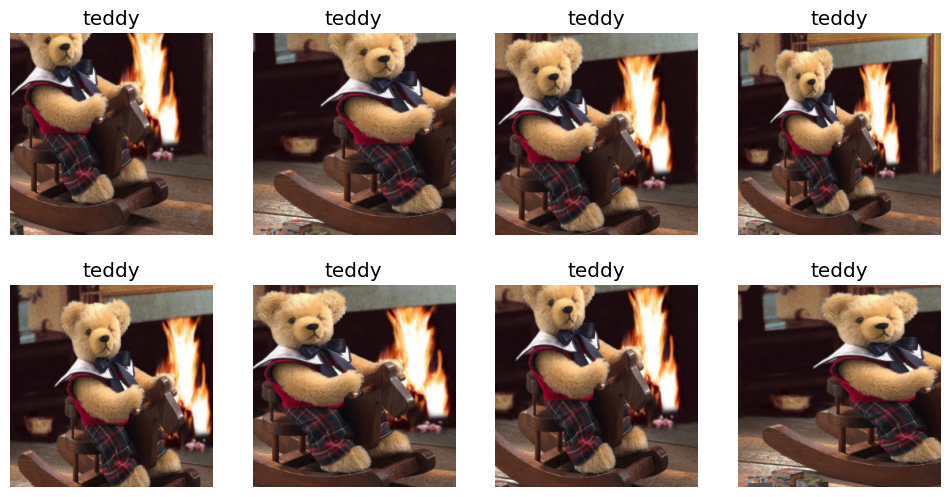

In [45]:
bears = bears.new(item_tfms=RandomResizedCrop(256, min_scale=0.36))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Taste of Data Augmentation!

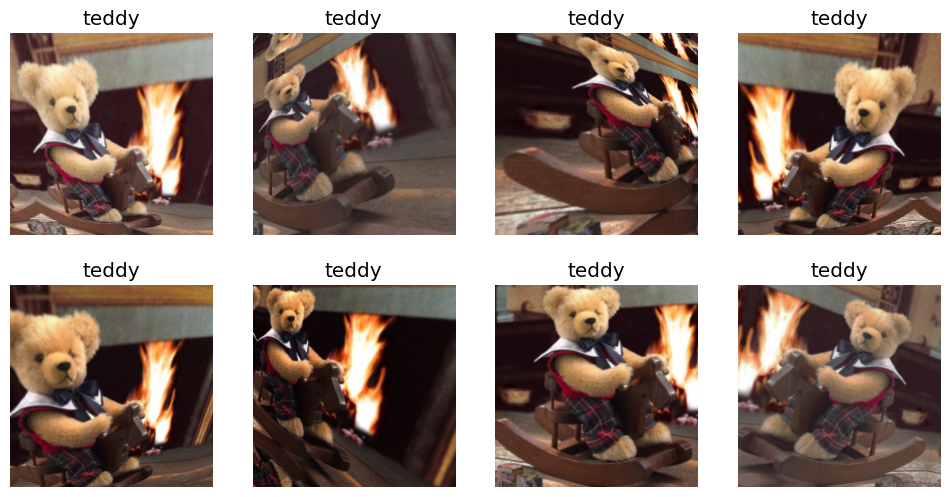

In [48]:
bears = bears.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Data Augmentation with Resize Random!

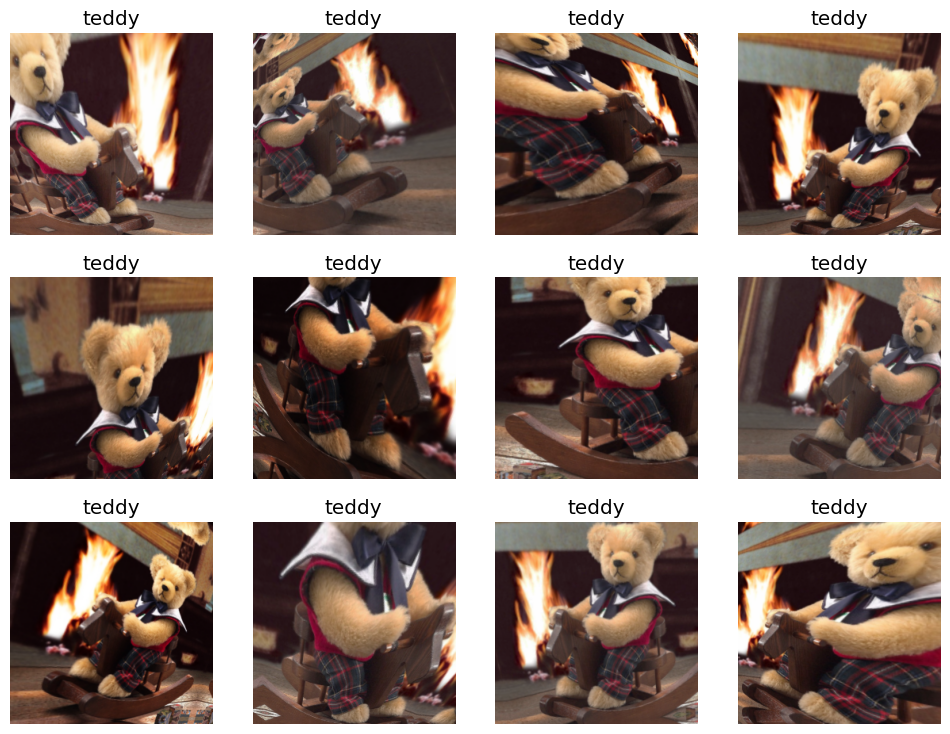

In [49]:
bears = bears.new(item_tfms=RandomResizedCrop(256, min_scale=0.36), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=12, nrows=3, unique=True)

# Step 4: Training Your Model, and Using It to Clean Your Data!

In [50]:
bears = bears.new(
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

### Let's create our learner and fine tune it!

In [51]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.1MB/s]


### Now let's see whether the mistakes the model is making!

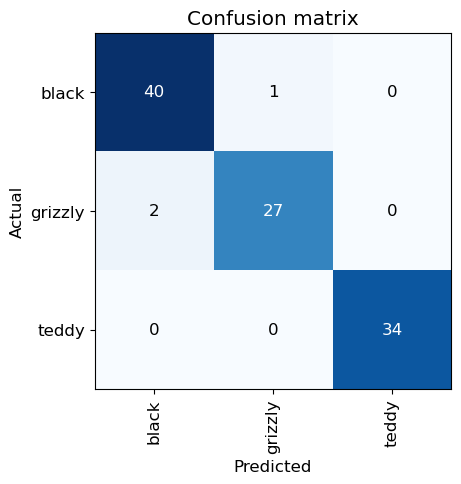

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Let's see the images with the highest loss in our dataset.

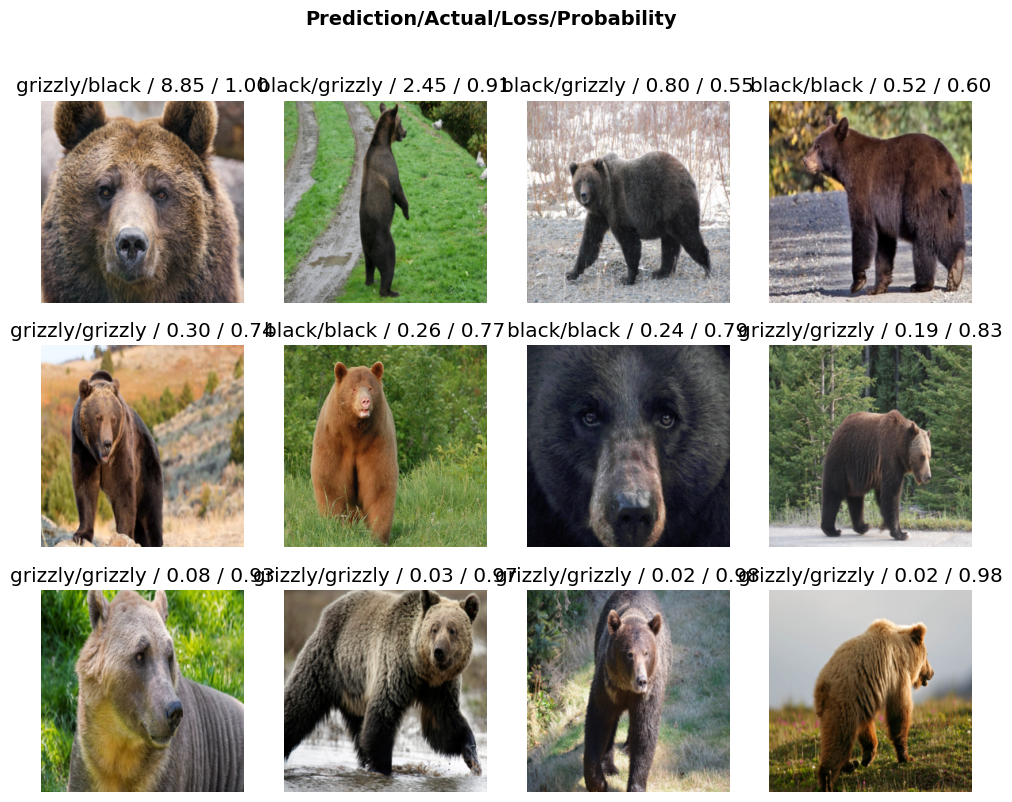

In [55]:
interp.plot_top_losses(12, nrows=3)

### fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [56]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### Apply the Changes into our data set!

In [57]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Step 5: Train the model Again with the updated dataset!

In [58]:
bears = bears.new(
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [60]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

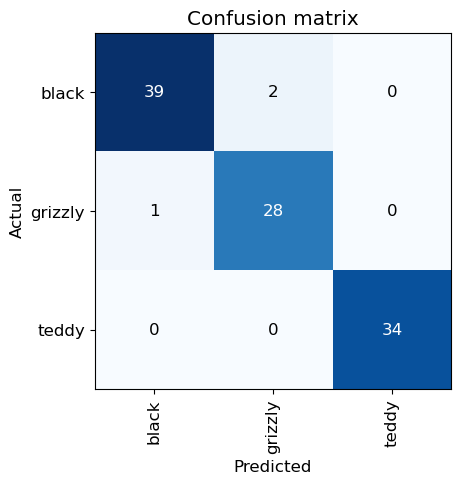

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

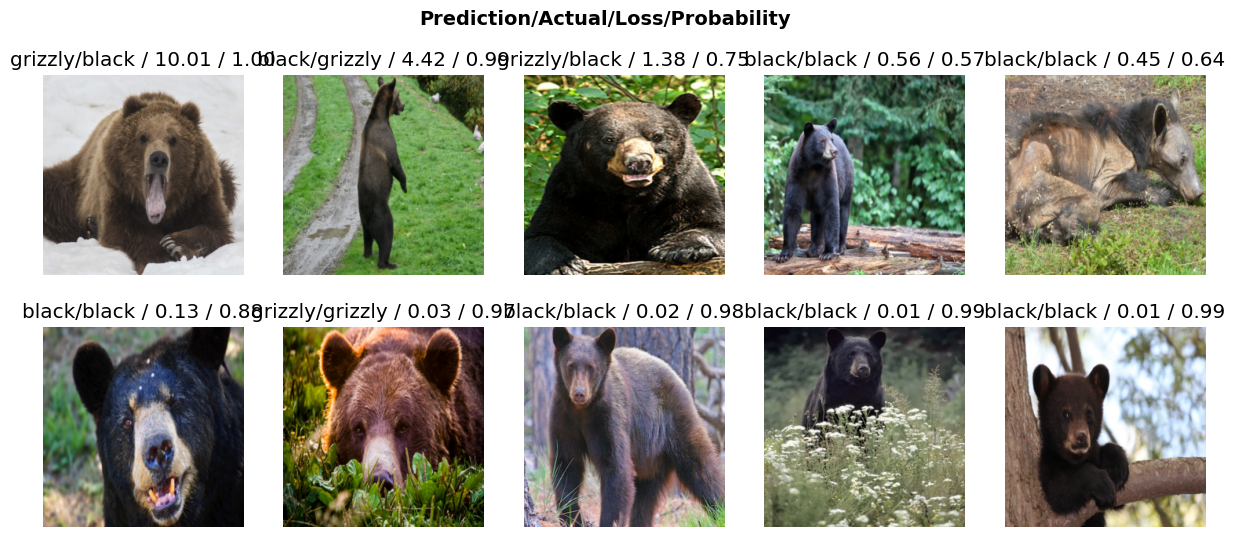

In [62]:
interp.plot_top_losses(10, nrows=2)

# Step 6: Save our model!

In [63]:
learn.export('model.pkl')

### Check that we have successfully exported the model.pkl file or not!

In [64]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('model.pkl')]

# Step 7: Load the model.pkl file 

In [65]:
learn_inf = load_learner(path/'model.pkl')

## Let's predict something using the image we downloaded earlier!

In [68]:
learn_inf.predict('images/grizzly_beer.jpg')

('grizzly', tensor(1), tensor([5.1673e-03, 9.9480e-01, 2.9515e-05]))

In [69]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

# Step 8: Creating a Notebook App from the Model!
### create a complete working web application using nothing but Jupyter notebooks!

In [70]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [80]:
btn_upload = SimpleNamespace(data = ['images/grizzly_beer.jpg'])

In [81]:
img = PILImage.create(btn_upload.data[0])

In [83]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(256,256))
out_pl

Output()

In [84]:
pred,pred_idx,probs = learn_inf.predict(img)

In [85]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9948')

In [86]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [87]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256,256))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [88]:
btn_upload = widgets.FileUpload()

In [89]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Step 9: Turning Your Notebook into a Real App

In [90]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00a 0:00:01
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.3 OK
